In [163]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# OSMNX

In [164]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os
import numpy as np

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [3]:
if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

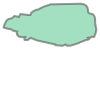

In [4]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

# OSMNX API

In [5]:
drive = ox.graph_from_polygon(hull, network_type='drive')
drive = ox.speed.add_edge_speeds(drive)

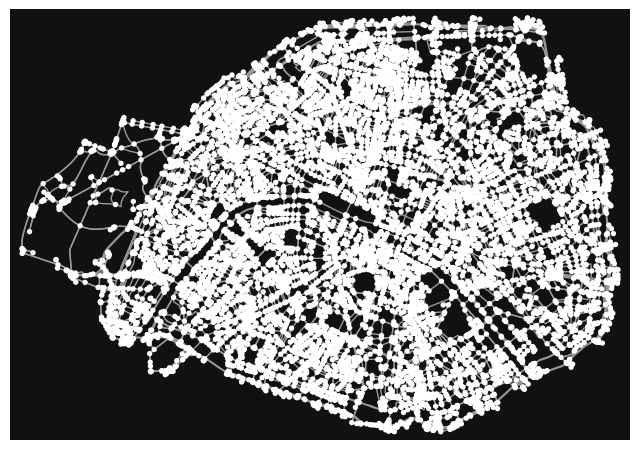

In [6]:
plot = ox.plot_graph(drive)

In [346]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [347]:
road_links = road_links.reset_index()
road_nodes = road_nodes.reset_index()

road_links.rename(columns={'u': 'a', 'v': 'b', 'speed_kph': 'speed'}, inplace=True)
road_links['time'] = road_links['length']/(road_links['speed']*1000/3600)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['a', 'b']] = road_links[['a', 'b']].astype(str)

# cleaning

In [348]:
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

In [349]:
road_links['geometry'] = road_links['geometry'].apply(simplify_link)
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='a', 
    b='b'
)

In [350]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

# export 

In [351]:
from quetzal.model.stepmodel import StepModel

sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'speed', 'time', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()

In [352]:
sm.road_links['highway'] = sm.road_links['highway'].astype(str)
irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]


In [353]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=10)


direct: 6072it [00:00, 22882.65it/s]
reversed: 6072it [00:00, 23314.94it/s]
5711it [00:00, 22158.17it/s]


In [354]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|██████████████████████| 10/10 [00:01<00:00,  9.42it/s]


<AxesSubplot: >

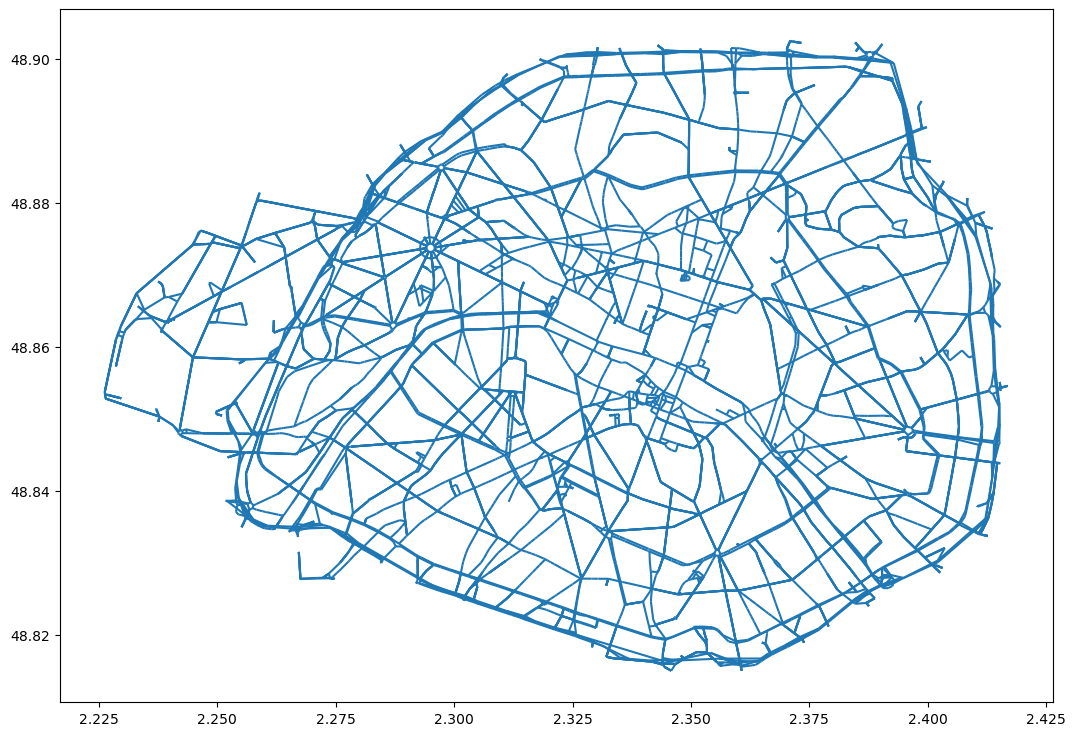

In [355]:
sm.road_links.plot()